# Cohort Analysis for Retention of Customers

> An analysis of customer <a href="https://corporatefinanceinstitute.com/resources/knowledge/other/cohort-analysis/">cohorts</a> at an online retail store.
- toc: true
- badges: true
- comments: true
- sticky_rank: 1
- categories: [cohort-analysis-for-customer-retention, exploratory-data-analysis, behavioural-analytics, python]

In [1]:
#hide
import datetime
import os
from operator import attrgetter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import seaborn as sns
from matplotlib.colors import LogNorm
from matplotlib.ticker import MultipleLocator

In [2]:
#hide
sns.set_context("talk")

## Background

[Cohort analysis](https://en.wikipedia.org/wiki/Cohort_analysis) is a branch of behavioural analytics that congregates customer data before conducting analysis. The underlying principle is to consider a group, or cohort, of customers who exhibit some common attributes within a finite period of time.

The purpose of using this technique is to understand customer engagement over the chosen period of time. For example, it might allow for an understanding of whether the business is really better engaging users over time or if this is in fact only increasing due to growth. Indeed separating these two concepts - growth and true customer engagement - is a vital benefit of this technique.

One grouping of customers in cohort analysis can be done based on when they first made a transaction at a retail store. We could break down cohorts by, for example, the month, week or day they first made a transaction at a store, and thus track monthly, weekly or daily cohorts. With the logic for grouping users into a cohort defined, we can then measure the business' retention of these cohorts to determine for how long customers continue to shop at a retail store relative to their first recorded transaction at that store. This is called an [acquisition cohort](https://www.appcues.com/blog/cohort-analysis) and we'll be focusing on this here.

## Objective

Here, we will focus on monthly user retention rate. We'll use Python to conduct cohort analysis on customer transaction data at an online retail store.

In [3]:
#hide
def show_df(df, nrows=None, header=None):
    """Show a few of the first and last rows of a DataFrame."""
    df_slice = df.head(nrows).append(df.tail(nrows)) if nrows else df
    if not header:
        header = f"First & Last {nrows} rows" if nrows else "All rows"
    display(df_slice.style.set_caption(header))


def show_df_dtypes_nans(df):
    """Show datatypes and number of missing rows in DataFrame."""
    display(
        df.isna()
        .sum()
        .rename("num_missing")
        .to_frame()
        .merge(
            df.dtypes.rename("dtype").to_frame(),
            left_index=True,
            right_index=True,
            how="left",
        )
        .style.set_caption("Column Datatypes and Missing Values")
    )


def summarize_df(df, col_dtype_to_show):
    if col_dtype_to_show == "object":
        # Get string dtype columns
        cols_to_show = list(df.select_dtypes("object"))
        # Get max length of string
        df_max = (
            df[cols_to_show]
            .astype(str)
            .apply(lambda x: x.str.len().max(), axis=0)
            .rename("max_length")
            .to_frame()
        )
    else:
        # Get non-string (numerical) dtype columns
        cols_to_show = list(set(list(df)) - set(list(df.select_dtypes("object"))))
        # Get max numerical value
        df_max = df[cols_to_show].max().rename("max_value").to_frame()
    col_dtype_to_show_str = col_dtype_to_show if col_dtype_to_show else "all"
    display(
        df_max.merge(
            df[cols_to_show].dtypes.rename("dtype").to_frame(),
            left_index=True,
            right_index=True,
            how="left",
        )
        .merge(
            df[cols_to_show].isna().sum().rename("num_missing").to_frame(),
            left_index=True,
            right_index=True,
            how="left",
        )
        .merge(
            df[cols_to_show]
            .dropna(how="any")
            .sample(1)
            .squeeze()
            .rename("single_non_nan_value")
            .to_frame(),
            left_index=True,
            right_index=True,
            how="left",
        )
        .style.set_caption(f"Summarizing {col_dtype_to_show_str} dtype columns")
    )

## About the Customer Data

The dataset we'll use is taken from the UCI repository and covers transaction data for an online-only retail company. The data is provided in a single `.xlsx` file.

## Get the Data

We'll download the data file to a file named `online_retail.xlsx` in the current working directory.

In [4]:
PROJ_ROOT_DIR = os.getcwd()

In [5]:
url = (
    "https://archive.ics.uci.edu/ml/machine-learning-databases/00352/"
    "Online%20Retail.xlsx"
)

d_weekdays = [
    "Monday",
    "Tuesday",
    "Wednesday",
    "Thursday",
    "Friday",
    "Saturday",
    "Sunday",
]

raw_data_filepath = os.path.join(
    PROJ_ROOT_DIR, os.path.basename(url).lower().replace("%20", "_")
)

In [6]:
#hide
if not os.path.exists(raw_data_filepath):
    r = requests.get(url)
    with open(raw_data_filepath, "wb") as f:
        f.write(r.content)

## Load Data

We'll now load the data into a `DataFrame` while parsing the `InvoiceDate` column as a datetyime format

In [7]:
dtypes_dict = {
    "Description": pd.StringDtype(),
    "StockCode": pd.StringDtype(),
    "Country": pd.StringDtype(),
    "CustomerID": pd.StringDtype(),
    "InvoiceNo": pd.StringDtype(),
    "UnitPrice": pd.Float64Dtype(),
    "Quantity": pd.Float64Dtype(),
}

In [8]:
%%time
df = pd.read_excel(
    raw_data_filepath,
    dtype=dtypes_dict,
    parse_dates=["InvoiceDate"],
)
display(
    df.head()
    .append(df.tail())
    .style.format("{:,.3f}", subset=["UnitPrice"])
    .format("{:,.0f}", subset=["Quantity"])
    .set_caption("First and last 5 rows")
)

CPU times: user 1min 4s, sys: 252 ms, total: 1min 4s
Wall time: 1min 19s


Each transaction covers a certain number of products. This quantity and the unit price of each product are available in the data. A text-based description of the order and the invoice date and time are provided. We won't be working with the time here so we'll only consider the date component of the `InvoiceDate` column.

Strictly for the purposes of cohort analysis of customer retention, we only require the `InvoiceDate` and `CustomerID` columns. But, in order to the clean the dataset (to be done next), we'll need to consider a subset of the other columns in the raw data.

The range of dates covering these transactions is shown below

In [9]:
#hide_input
print(
    f"Raw data includes {len(df):,} transactions, covering "
    f"{df['InvoiceDate'].min().strftime('%Y-%m-%d')} to "
    f"{df['InvoiceDate'].max().strftime('%Y-%m-%d')}."
)

Raw data includes 541,909 transactions, covering 2010-12-01 to 2011-12-09.


We have 13 months of the transaction data for this online retailer.

## Data Cleaning

We'll perform some basic cleaning of the two quantitative columns in the dataset. Descriptive statistics for these are shown below

In [10]:
#hide_input
display(
    df[["Quantity", "UnitPrice"]]
    .describe()
    .style.format("{:,.3f}")
    .set_caption("Statistics about raw data")
)

There are transactions with negative values in both of these columns. These could be transactions that resulted in a product return.

We'll extract the invoice numbers for the transactions that were returns

In [11]:
returns = df.query("Quantity < 0")

The first five returns are shown below

In [12]:
#hide_input
display(
    returns.head()
    .style.format("{:,.3f}", subset=["UnitPrice"])
    .format("{:,.0f}", subset=["Quantity"])
)

We'll also count missing values in the full dataset and view a single sample value in each column. These are shown below

In [13]:
#hide_input
summarize_df(df, "string")
summarize_df(df, "Float64")
show_df_dtypes_nans(df)

Since the `CustomerID` column will be needed later, we can't keep transactions without a value in this field. So, we'll drop such transactions and re-display the descriptive statistics

In [14]:
#hide_input
display(
    df.dropna(subset=["CustomerID"])[["Quantity", "UnitPrice"]]
    .describe()
    .style.format("{:,.3f}")
    .set_caption("Statistics about raw data")
)

The negative `UnitPrice`s have been removed but negative `Quantity` values remain. We'll exclude the transactions with a negative `Quantity`

In [15]:
df = df.dropna(subset=["CustomerID"]).query("Quantity > 0")

The descriptive statistics of the cleaned dataset are shown below

In [16]:
#hide_input
display(
    df.dropna(subset=["CustomerID"])[["Quantity", "UnitPrice"]]
    .describe()
    .style.format("{:,.3f}")
    .set_caption("Statistics about cleaned data")
)

The number of missing values and a sample value for each column in the cleaned dataset are again displayed

In [17]:
#hide_input
summarize_df(df, "string")
summarize_df(df, "Float64")
show_df_dtypes_nans(df)

We'll use this cleaned version of the dataset for further analysis.

Briefly exploring the dataset, we can show the number of transactions by hour of day and day of the week

In [18]:
#hide_input
records = []
for day in d_weekdays:
    for hour in range(0, 23+1):
        records.append({"weekday": day, "inv_hour": hour})
df_time = pd.DataFrame.from_records(records)

dtime_hmap = df.assign(
    inv_hour=df["InvoiceDate"].dt.hour
).assign(
    weekday=df["InvoiceDate"].dt.day_name()
).groupby(
    ["weekday", "inv_hour"], as_index=False
)["InvoiceNo"].count()
dtime_hmap = df_time.merge(
    dtime_hmap,
    on=["weekday", "inv_hour"],
    how="left"
).fillna(0).astype({"InvoiceNo": int})

dtime_hmap_pivotted = dtime_hmap.pivot(
    index="inv_hour",
    columns="weekday",
    values="InvoiceNo",
)[d_weekdays]
display(dtime_hmap_pivotted)

weekday   Monday  Tuesday  Wednesday  Thursday  Friday  Saturday  Sunday
inv_hour                                                                
0              0        0          0         0       0         0       0
1              0        0          0         0       0         0       0
2              0        0          0         0       0         0       0
3              0        0          0         0       0         0       0
4              0        0          0         0       0         0       0
5              0        0          0         0       0         0       0
6              0        0          0         1       0         0       0
7             61       65         59        64     130         0       0
8           1564     1711       1818      1765    1833         0       0
9           4348     4546       4078      4572    4376         0      25
10          6132     6615       6944      7548    7223         0    3537
11          7506     8495       8389      7186    7299         0   10217
12         10731    12036      12932     13056    9888         0   13426
13         10596    10429      11321     11595    8417         0   11673
14          9213     9614       8832      9260    7329         0    9879
15          7705     7299       7855      7732    4726         0   10055
16          4065     3633       4223      6098    2111         0    3963
17          2978     1964       2404      4323    1403         0       0
18             0       69          0      2858       2         0       0
19             0        0         15      3218      89         0       0
20             0        0         18       776       8         0       0
21             0        0          0         0       0         0       0
22             0        0          0         0       0         0       0
23             0        0          0         0       0         0       0

Although this is an online retailer, they strangely don't receive purchase transactions during early hours of the morning or late hours of the night, or even on Saturdays.

## Extracting Variables to Define Monthly Customer Retention

We'll append new columns to the dataset for
- the date (year and month) of the first transaction for each customer
  - since we're looking at the monthly cohort, we only need the month of the date and not the day of the month
- the current transaction's year and month

In [19]:
df["FirstInvoiceDate"] = (
    df.groupby("CustomerID")["InvoiceDate"].transform("min").dt.strftime("%Y-%m")
)
df["Invoice_YearMonth"] = df["InvoiceDate"].dt.strftime("%Y-%m")

Both of these columns will be used for analysis in the next step. The `FirstInvoiceDate` represents cohorts of customers who all performed their first transaction during the same month in the same year.

## Data Transformation

We'll now get the date of the first transaction performed by a given cohort and the date of the every transaction. Since the first transaction also falls under every transaction, the first row of this combination of date columns will be the same.

To do this, we'll count the number of customers who made transactions for every grouping of the first invoice date (`FirstInvoiceDate`) and invoice date (`Invoice_YearMonth`). This is done below

In [20]:
#collapse
cohorts = (
    df.groupby(["FirstInvoiceDate", "Invoice_YearMonth"], as_index=False)["CustomerID"]
    .nunique()
    .rename(columns={"CustomerID": "num_customers"})
)

and the first and last five rows of the output are shown below

In [21]:
#hide_input
show_df(cohorts, 5)

This has transformed the data into an aggregated form by year-month date rather than keeping it on a per-transaction basis.

The reason for doing this is to calculate the time difference (in months) between each cohort's first and all transaction dates. The above data transformation facilitates this calculation.

As mentioned above, for a cohort, the first transaction date also appears as one of the dates of all the transactions. For this reason, the first row of each cohort always has the same date in the `FirstInvoiceDate` and `Invoice_YearMonth` columns and, as we'll see next, the time difference will be zero months for this row.

Within each grouping above, we will append a column with the difference in months ([1](https://stackoverflow.com/a/55046846/4057186)) between the first and every transaction date

In [22]:
cohorts["First_to_Current_InvoiceMonth"] = (
    pd.to_datetime(cohorts["Invoice_YearMonth"]).dt.to_period("M")
    - pd.to_datetime(cohorts["FirstInvoiceDate"]).dt.to_period("M")
).apply(attrgetter("n"))

The first and last five rows of the transformed data, including this appended column, are shown below

In [23]:
#hide_input
show_df(cohorts, 5)

As expected, the first row of every grouping is zero. For every cohort which only had transactions in a single month of a single year, the only time difference is zero months (see the last row of the above output).

## Customer Retention Matrix

Finally, we'll re-shape this aggregated version of the data to have the first invoice date as the rows and the average transaction price for all subsequent transactions, by month, in the columns. This is known as a [retention matrix](https://www.holistics.io/blog/calculate-cohort-retention-analysis-with-sql/) and is done below

In [24]:
df_cohort_pivotted = cohorts.pivot_table(
    index="FirstInvoiceDate",
    columns="First_to_Current_InvoiceMonth",
    values="num_customers",
)
df_cohort_pivotted = df_cohort_pivotted.add_prefix("Month ")

This re-shaped version of the aggregated data is shown below

In [25]:
#hide_input
display(
    df_cohort_pivotted.head(5)
    .append(df_cohort_pivotted.tail(5))
    .style.format("{:,.0f}", subset=list(df_cohort_pivotted)[1:])
    .format("{:,.0f}", subset=["Month 0"])
    .set_caption("First and last 5 rows")
)

We can see that the first column contains the following
- row label (eg. *2010-12*)
  - this is the first combination of year and month in which transactions for a given cohort were performed (i.e. this combination defines a unique cohort; in this dataset, there are 10 such cohorts)
- numerical value (eg. 885)
  - this is the number of customers who made transactions during that combination of year and month (i.e. the number of customers with transactions, for the cohort defined by the row label explained above)

As seen from the raw data, there are 13 months of transaction data so we have 13 columns in the retention matrix.

## Visualizing Customer Retention

We'll start visualizing this data by considering all customers together rather than in cohorts by the month of their first transaction. This are shown below

In [26]:
#hide_input
overall_retention = cohorts.groupby(
    "First_to_Current_InvoiceMonth",
    as_index=False,
)["num_customers"].sum()
overall_retention["pct_users_retained"] = 100 * (
    overall_retention["num_customers"] / overall_retention.iloc[0]["num_customers"]
)
display(overall_retention)

First_to_Current_InvoiceMonth  num_customers  pct_users_retained
0                               0           4339          100.000000
1                               1            976           22.493662
2                               2            942           21.710071
3                               3            927           21.364370
4                               4            905           20.857340
5                               5            878           20.235077
6                               6            804           18.529615
7                               7            725           16.708919
8                               8            680           15.671814
9                               9            641           14.772989
10                             10            509           11.730814
11                             11            494           11.385112
12                             12            235            5.415994

We can visualize this as a line chart in a single dimension, rather than as a retention matrix which will capture each cohort on the second dimension

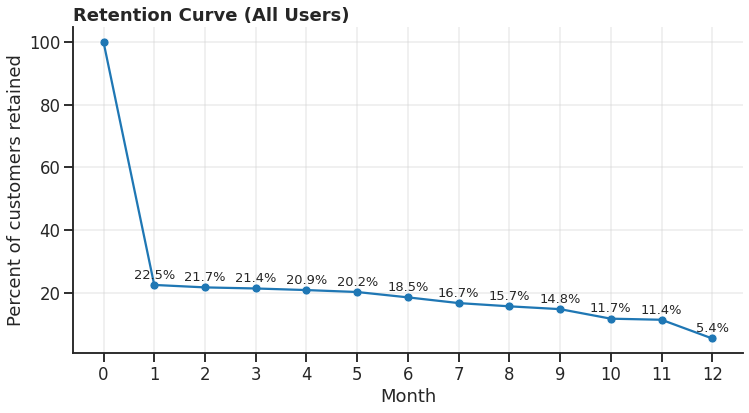

In [27]:
#hide_input
with sns.axes_style("ticks"):
    _ = sns.lineplot(
        x="First_to_Current_InvoiceMonth",
        y="pct_users_retained",
        data=overall_retention,
        legend=False,
    )
    ax = sns.scatterplot(
        x="First_to_Current_InvoiceMonth",
        y="pct_users_retained",
        data=overall_retention,
        legend=False,
    )
    ax.set_title(
        "Retention Curve (All Users)",
        loc="left",
        fontweight="bold",
    )
    for _, row in overall_retention.iloc[1:].iterrows():
        ax.annotate(
            f"{row['pct_users_retained']:.1f}%",
            (row["First_to_Current_InvoiceMonth"], row["pct_users_retained"]+2),
            ha="center",
            fontsize=13,
            
        )
    ax.xaxis.set_major_locator(MultipleLocator(1))
    ax.set_xlabel("Month")
    ax.set_ylabel("Percent of customers retained")
    ax.grid(color="lightgrey", alpha=0.45)
    sns.despine()
    fig = plt.gcf()
    fig.set_figheight(6)
    fig.set_figwidth(12)

This customer retention curve clearly shows that approximately 75 percent of customers stop making transactions on the online store after the first month. We see a slow but steady decline over the first five months following the initial transaction. Then we see a larger drop after the fourth month to under 19 percent retention, followed by another steady decrease until the end of the eighth month when retention falls to below 12 percent. At the twelveth month after the initial transaction, about 5 percent of users are still active on the online store.

Customers are not quickly getting to the underlying value of the offerings on the web store. Improving the online shopping experience at the store could help get the customer to the core value of the business as quickly as possible, and could boost retention in the process.

We're also ready to plot the retention matrix data by cohort and inspect the change in number of customers by month of the year. For ease of reading, we will convert these numbers of customers per month, for each cohort, into a percent relative to the first month (column named `Month 0`) in which transactions were performed by that cohort

In [28]:
cohort_sizes = df_cohort_pivotted["Month 0"]
retention = df_cohort_pivotted.divide(cohort_sizes, axis=0)

The resulting retention matrix is shown below

In [29]:
#hide_input
display(
    retention.head()
    .append(retention.tail())
    .style.format("{:,.3f}")
    .set_caption("First and last 5 rows")
)

We'll now plot a heatmap of the retention matrix annotated with these fractions expressed as a percentage

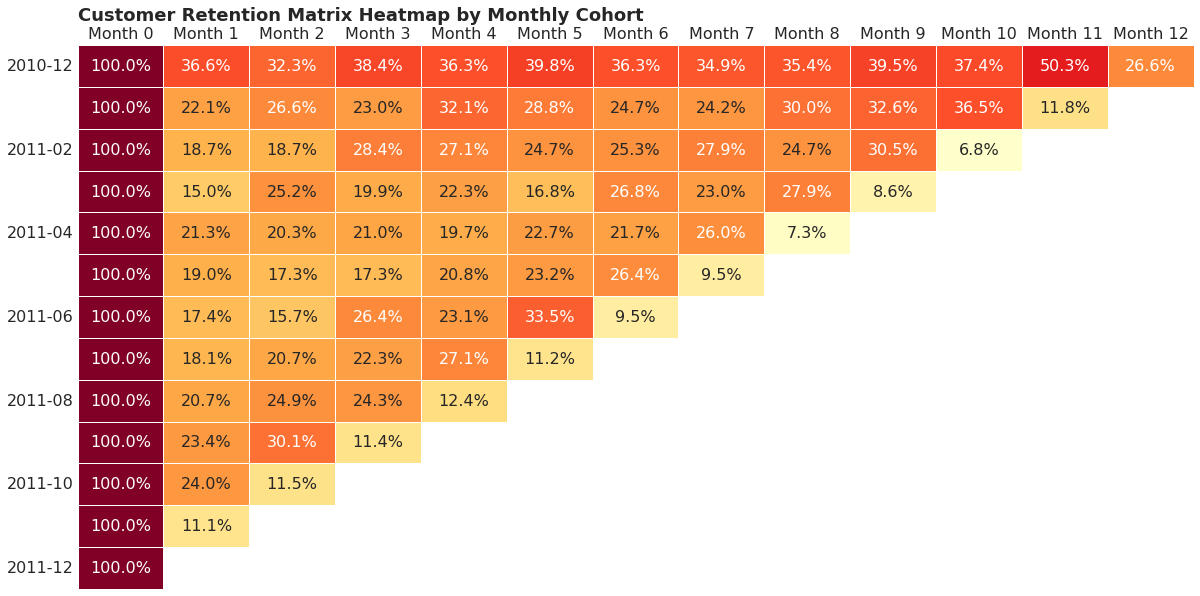

In [30]:
#hide_input
with sns.axes_style("ticks"):
    ax = sns.heatmap(
        data=retention,
        linewidths=0.5,
        norm=LogNorm(),
        cmap="YlOrRd",
        annot=True,
        fmt=".1%",
        cbar=False,
        annot_kws={"size": 16},
    )
    ax.set_title(
        "Customer Retention Matrix Heatmap by Monthly Cohort",
        loc="left",
        fontweight="bold",
        fontsize=18,
    )
    ax.set_xlabel(None)
    ax.set_ylabel(None)
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=16)
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=16)
    sns.despine(top=True, right=True, left=True, bottom=True)
    ax.xaxis.set_tick_params(length=0)
    ax.yaxis.set_tick_params(length=0)
    plt.tick_params(
        axis="both",
        which="major",
        labelbottom=False,
        bottom=False,
        top=False,
        labeltop=True,
    )
    fig = plt.gcf()
    fig.set_figheight(10)
    fig.set_figwidth(20)

The annotation in each cell of this heatmap is the fraction of retained customers (taken as the fraction of the initial size of the cohort that makes monthly transactions after the first month). The stronger the retention the darker the shade of red on this heatmap.

Since the monthly columns were ratioed to the first column (first month of transactions per cohort), they cannot be higher in value (or percentage from 0 percent to 100 percent) than the first column. In terms of the heatmap color scheme used here, this means they cannot appear in a darker shade of red than the first column. At best, they could match the shade of red as the first column but they would need to also be 100 percent. As we can see, there isn't a month in which the number of unique customers, belonging to a given cohort, making transactions was the same as during the first month. We'll talk about interpretation of this heatmap next.

By calculating customer retention in these monthly cohorts, we can visualize how long each cohort continues to use the store after their first transaction.

We can see that there isn't an increasing or decreasing trend of customer behaviour within a cohort. We don't consistently see more or less customers making transactions in the months since the first transaction. This is true for all cohorts.

For every cohort, the last month for which we have transaction data results in the fewest customers making transactions. This is likely since we don't have transactions for the entire last month. As we saw from the raw data, the last month for which we have transaction data is December 2011 and we only have nine days of data for this month.

A larger fraction of the first cohort makes transactions after the first month than any other cohort. After the first month, there is no month in which any of the other cohorts outperform the first cohort in the percent of customers making transactions. Even so, there is a nearly a 65 percent drop in customer retention after the first month in this first cohort and between approximately 70 to 90 percent drop in the other cohorts across the subsequent 12 months.

## Summary

Cohort analysis can focus on various quantitative metrics. Here, we focused on customer retention at an online retail business. Cohort analysis for customer retention is a powerful tool for developing an understanding of customer behaviour. It facilitates building up an understanding of the drivers for growth, customer engagement and ultimately revenue. Here, it allowed for a direct understanding of which customers leave a business and when they leave. With additional data, it would allow for develpoing an understanding of why customer interaction dropped after the initial month and to make more focused interpretations of the data in terms of their impact on the business.